In [11]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
import glob
import random

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

In [12]:
def transform_node_to_matrix(node):
    model_matrix = np.identity(4)
    for child in reversed(node.childNodes):
        if child.nodeName == "translate":
            x = float(child.getAttribute('x'))
            y = float(child.getAttribute('y'))
            z = float(child.getAttribute('z'))
            z *= -1 # flip because of torch3d frame def
            translate_vec = Vector3([x, y, z])
            trans_matrix = np.transpose(pyrr.matrix44.create_from_translation(translate_vec))
            model_matrix = np.matmul(model_matrix, trans_matrix)
        if child.nodeName == "scale":
            scale = float(child.getAttribute('value'))
            scale_vec = Vector3([scale, scale, scale])
            scale_matrix = np.transpose(pyrr.matrix44.create_from_scale(scale_vec))
            model_matrix = np.matmul(model_matrix, scale_matrix)
            
    return model_matrix

def pose_loss_single_human(newHuman, oldHuman):
    if len(oldHuman) == 0:
        return -1
    if len(newHuman) == 0:
        return 0
    new_detected = 0
    old_detected = 0
    for part in range(18):
        if newHuman[0][part] != -1:
            new_detected += 1
        if oldHuman[0][part] != -1:
            old_detected += 1
    return new_detected / old_detected

def transform_node_to_R_T(node):
    eye = node.getAttribute('origin').split(',')
    eye = [float(i) for i in eye]
    at = node.getAttribute('target').split(',')
    at = [float(i) for i in at]
    up = node.getAttribute('up').split(',')
    up = [float(i) for i in up]
    
    R, T = look_at_view_transform(
        eye=[eye], 
        at=[at], 
        up=[up]
    )
    return R, T

def load_shape(shape, prefix_dir):
    if shape is None:
        return None
    device = torch.device("cuda:0")
    char_filename_node = shape.getElementsByTagName('string')[0]
    char_filename = char_filename_node.getAttribute('value')
    obj_filename = os.path.join(prefix_dir, char_filename)
    mesh = load_objs_as_meshes([obj_filename], device=device)
    verticies, faces = mesh.get_mesh_verts_faces(0)
    texture = mesh.textures.clone() if mesh.textures is not None else None
    
    
    
    transform_node = shape.getElementsByTagName('transform')
    if len(transform_node) == 0:
        verticies[:, 2] *= -1 # flip because of torch3d frame def
        return verticies, faces, texture
    # apply transform
    transform_node = transform_node[0]
    model_matrix =  transform_node_to_matrix(transform_node)
    model_matrix = torch.from_numpy(model_matrix).cuda().double() 
    
    # make coordiantes homegenos
    new_row = torch.ones(1, verticies.shape[0], device=device)
    vetrices_homo = torch.cat((verticies.t(), new_row)).double() 
    
    # transform
    vetrices_world = torch.chain_matmul(model_matrix, vetrices_homo).t()[:, :3]
    return vetrices_world.float(), faces, texture

def mitsuba_scene_to_torch_3d(master_scene, prefix_dir=''):
    device = torch.device("cuda:0")
    master_doc = xml.dom.minidom.parse(master_scene)
    camera = master_doc.getElementsByTagName('sensor')[0]
    camera_transform = camera.getElementsByTagName('transform')[0]
    R, T = transform_node_to_R_T(camera_transform.getElementsByTagName('lookat')[0])
    # TODO figure out how to set camera params
    cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=1000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )
    
    
    character = None
    tshirt = None
    ground = None
    
    shapes = master_doc.getElementsByTagName('shape')
    for i in range(len(shapes)):
        if shapes[i].getAttribute("id") == 'character':
            character = shapes[i]
        if shapes[i].getAttribute("id") == 'simulated':
            tshirt = shapes[i]
        if shapes[i].getAttribute("id") == 'place.000000':
            ground = shapes[i]
    
    tshirt_vetrices, tshirt_faces, tshirt_texture = load_shape(tshirt, prefix_dir)
    character_vetrices, character_faces, character_texture = load_shape(character, prefix_dir)
#     ground_vetrices, ground_faces, ground_texture = load_shape(ground, prefix_dir)
    
    texTshirt = torch.ones_like(tshirt_vetrices).cuda()
    tex2 = torch.ones_like(character_vetrices).cuda()
#     tex3 = torch.ones_like(ground_vetrices).cuda()
    texTshirt[:, 1:] *= 0.0  # red
    # person
    tex2[:, 0] *= 0.88
    tex2[:, 1] *= 0.67
    tex2[:, 2] *= 0.41
    #tex3 [:, :2] *= 0.3  # blue
    # tex = torch.cat([texTshirt, tex2, tex3])[None]
    tex = torch.cat([texTshirt, tex2])[None]
    textures = Textures(verts_rgb=tex.cuda())
    
    # verts = torch.cat([tshirt_vetrices,character_vetrices, ground_vetrices]).cuda()
    verts = torch.cat([tshirt_vetrices,character_vetrices]).cuda()
    
    character_faces = character_faces + tshirt_vetrices.shape[0]  
#     ground_faces = ground_faces  + character_vetrices.shape[0] + tshirt_vetrices.shape[0]  
#     faces = torch.cat([tshirt_faces, character_faces, ground_faces]).cuda()  
#     mesh = Meshes(verts=[verts], faces=[faces], textures=textures)
    faces = torch.cat([tshirt_faces, character_faces]).cuda()  
    mesh = Meshes(verts=[verts], faces=[faces], textures=textures)
    
    optmization_input = {
        "texTshirt": texTshirt,
#         "texOther": torch.cat([tex2, tex3]),
        "texOther": torch.cat([tex2]),
        "verticies": verts, 
        "faces": faces,
        "R": R[0],
        "T": T[0]
    }
        
    return mesh, cameras, optmization_input
def get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt, 
        model, 
        body_estimation, 
        renderer
    ):
    
    (canvas_orig, 
     candidate_orig,
     subset_orig,
     heatmap_avg_orig,
     paf_avg_orig) = get_body_image_from_mesh(test_mesh, body_estimation, renderer, test_camera)

    tex = torch.cat([model.texTshirt, model.texOther]).repeat(1, 1, 1)
    textures = Textures(verts_rgb=tex.cuda())    
    noise_mesh = Meshes(verts=[test_opt["verticies"]], faces=[test_opt["faces"]], textures=textures)
    
    (canvas_noise, 
     candidate_noise,
     subset_noise,
     heatmap_avg_noise,
     paf_avg_noise) = get_body_image_from_mesh(noise_mesh, body_estimation, renderer, test_camera)
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    
    return canvas_orig, canvas_noise, metric

    
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer, cameras=None):
    if cameras is None:
        images = renderer(cur_mesh)
    else:
        images = renderer(cur_mesh, cameras=cameras)
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt", 
        reinit = True,
        name = name,
        config={
            "epochs": 1,
            "learning_rate": 0.2,
            "batch_size": 8,
            "optimizer": 'ADAM'
        }
    )
    
    return run 

def get_scenes_filenames(directory, include_filter=[], lim=10000000):
    scenes = []
    
    for file in tqdm(glob.glob(f"{directory}/*.xml")):
        if len(include_filter) == 0:
            scenes.append(file)
        else:
            for mesh_name in include_filter:
                if mesh_name in file:
                    scenes.append(file)
                    break
        
        if len(scenes) > lim:
            break
    # shuffel scenes due to naming 
    random.seed(42)
    random.shuffle(scenes)
    
    return scenes

class Model(nn.Module):
    def __init__(self, texTshirt, texOther, renderer, body_estimation, batch_size):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.texOther = texOther
        self.body_estimation = body_estimation
        self.cur_meshes = None
        self.batch_size = batch_size
        
        self.texTshirt = nn.Parameter(
            torch.zeros_like(texTshirt).to(self.device)
        )
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((self.batch_size, 19, 64, 64), device=self.device)
        self.zero_paf = torch.zeros((self.batch_size, 38, 64, 64), device=self.device)
        
    def forward(self, verts, faces, R, T):
        tex = torch.cat([self.texTshirt, self.texOther]).repeat(self.batch_size, 1, 1)
        textures = Textures(verts_rgb=tex.cuda())
        
        self.cur_meshes = Meshes(verts=verts, faces=faces, textures=textures)
        
        cameras = OpenGLPerspectiveCameras(
            znear=0.1,
            zfar=1000,
            fov=15,
            degrees=True,
            device=device, 
            R=R, 
            T=T
        )
        
        images = self.renderer(self.cur_meshes, cameras=cameras)
        
        #
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.zero_heatmap)
        ob_val_paf = self.objective(paf, self.zero_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, images

In [13]:
ORIG_SHAPE = (512, 512, 3)
DATA_ROOT = 'data/radek'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_SET_NAME = 'tshirt_torch'
snapshot_name = f'../snapshots/torch3d_tshirt_{DATA_SET_NAME}.npy'
train_dir = f'../data/{DATA_SET_NAME}/train'
test_dir = f'../data/{DATA_SET_NAME}/test'

train_scenes = get_scenes_filenames(train_dir)
test_scenes = get_scenes_filenames(test_dir)
print(len(train_scenes))
print(len(test_scenes))

master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras, optmization_input = mitsuba_scene_to_torch_3d(master_scene, DATA_ROOT)

100%|██████████| 200/200 [00:00<00:00, 647269.14it/s]

1800
200


In [14]:
raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)


Text(0.5, 1.0, 'Pytorch3d')

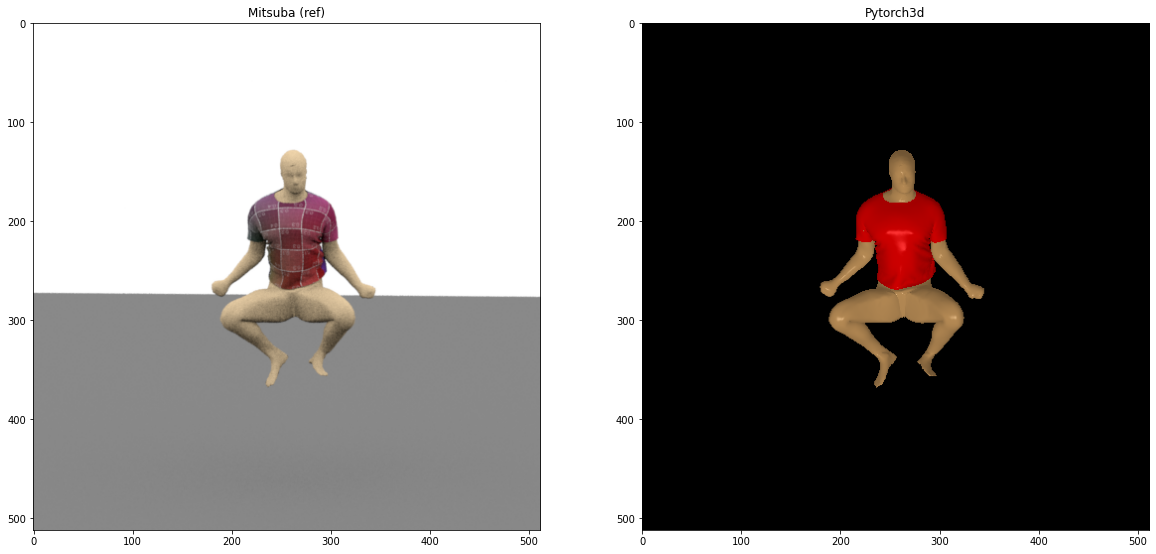

In [15]:
image = renderer(mesh)   # (1, H, W, 4)
ref_image = cv2.imread('data/radek/out.png')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ref_image)

ax.set_title("Mitsuba (ref)")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

In [16]:
run = wandb_init('torch3d')
steps = len(train_scenes) // run.config.batch_size

ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

# Initialize a model using the renderer, mesh and reference image
model = Model(
    texTshirt=optmization_input["texTshirt"], 
    texOther=optmization_input["texOther"], 
    renderer=renderer,
    body_estimation=body_estimation,
    batch_size=run.config.batch_size
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


In [17]:
global_step = 0
for epoch in range(run.config.epochs):
    print(f"run {epoch + 1}/{run.config.epochs}")
    for step in tqdm(range(steps)):
        optimizer.zero_grad()
        
        batch_verts = []
        batch_faces = []
        batch_R = []
        batch_T = []
        
        for i in range(step * run.config.batch_size, (step * run.config.batch_size) + run.config.batch_size):
            _, _, opt_input = mitsuba_scene_to_torch_3d(train_scenes[i], train_dir)
            batch_verts.append(opt_input["verticies"])
            batch_faces.append(opt_input["faces"])
            batch_R.append(opt_input["R"])
            batch_T.append(opt_input["T"])
        
        loss, cur_image = model(
            torch.stack(batch_verts), 
            torch.stack(batch_faces), 
            torch.stack(batch_R), 
            torch.stack(batch_T), 
        )
        
        loss.backward()
        optimizer.step()
        wandb.log({'loss': loss.item()}, step=global_step)
        global_step += 1

  0%|          | 0/225 [00:00<?, ?it/s]

run 1/1


 56%|█████▌    | 126/225 [08:15<06:26,  3.90s/it]

KeyboardInterrupt: 

In [ ]:
canvas_orig_list = []
canvas_noise_list = []
metric_list = []
i = 0
for test_scene in test_scenes:
    test_mesh, test_camera, test_opt = mitsuba_scene_to_torch_3d(test_scene, test_dir)
    
    canvas_orig, canvas_noise, metric = get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt,
        model, 
        body_estimation, 
        renderer
    )
    canvas_orig_list.append(canvas_orig)
    canvas_noise_list.append(canvas_noise)
    metric_list.append(metric)
    i += 1

../data/tshirt_torch/test/00010_mesh50_animated.xml
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh50_animated/14/14_14/simulated/tshirt_final_fine/01130_00.obj
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh50_animated/14/14_14/frame_04320.obj
../data/tshirt_torch/test/00194_mesh16_animated.xml
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh16_animated/05/05_01/simulated/tshirt_final_fine/00080_00.obj
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh16_animated/05/05_01/frame_00120.obj
../data/tshirt_torch/test/00097_mesh23_animated.xml
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh23_animated/14/14_01/simulated/tshirt_final_fine/00300_00.obj
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh23_animated/14/14_01/frame_01000.obj
../data/tshirt_torch/test/00134_mesh50_animated.xml
../data/tshirt_torch/test/meshes/SPRING_MALE_RESAMPLED/mesh50_animated/127/127_13/simulated/tshirt_final_fine/00074_00.obj
../data/tshirt_tor

In [15]:
canvas_orig_list_filtered, canvas_noise_list_filtered, metric_list_filtered = zip(*(
    (canvas_orig, canvas_noise, metric) for canvas_orig, canvas_noise, metric in zip(canvas_orig_list, canvas_noise_list, metric_list) if metric >= 0)
)

In [16]:
print(f"Avg metric: {np.mean(metric_list_filtered)} of {len(metric_list_filtered)} test samples")
wandb.log({'avgMetric': np.mean(metric_list_filtered)})

Avg metric: 0.28179897609487625 of 99 test samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

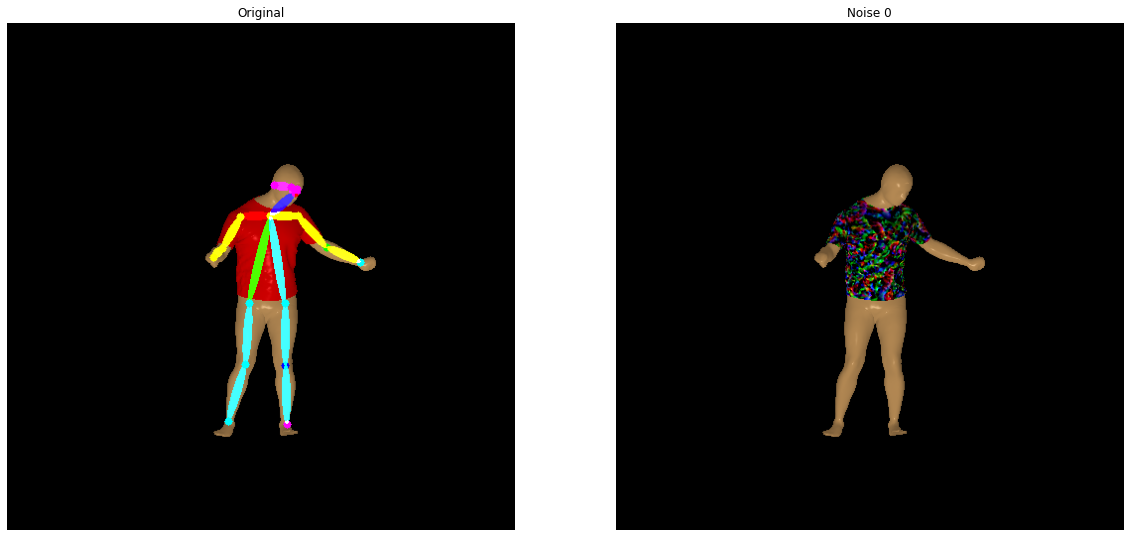

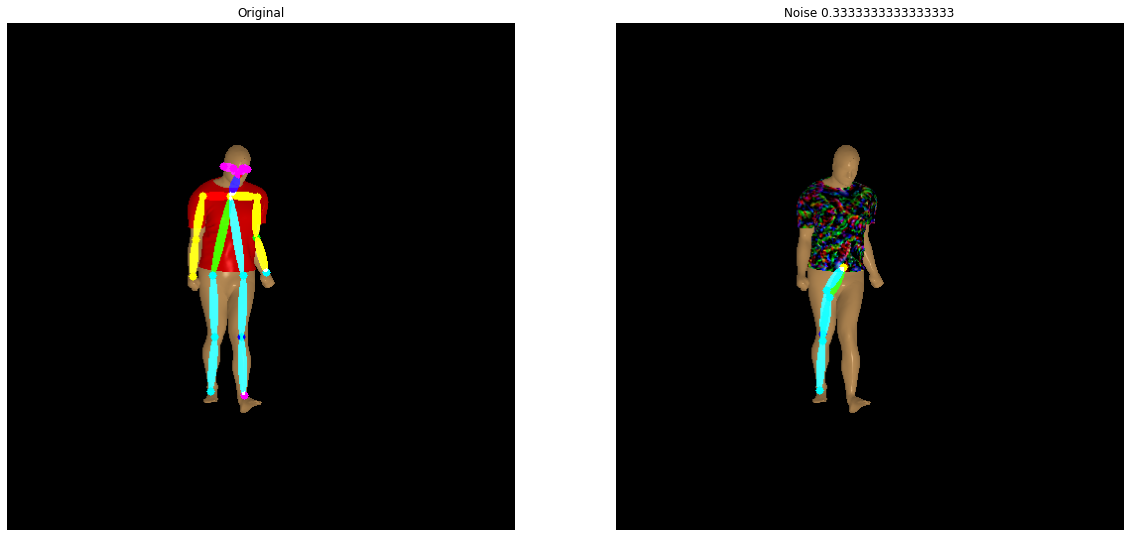

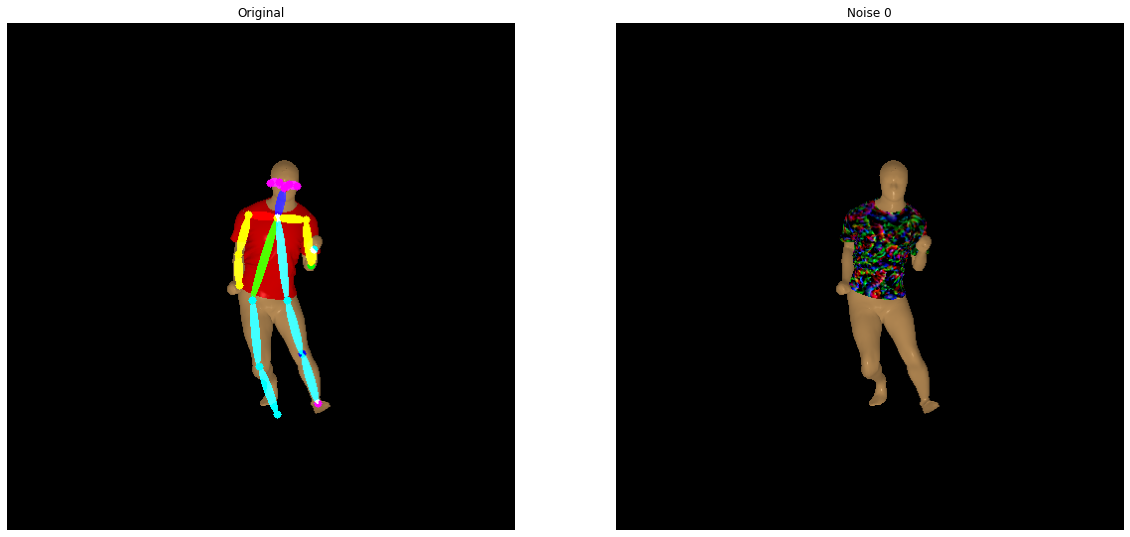

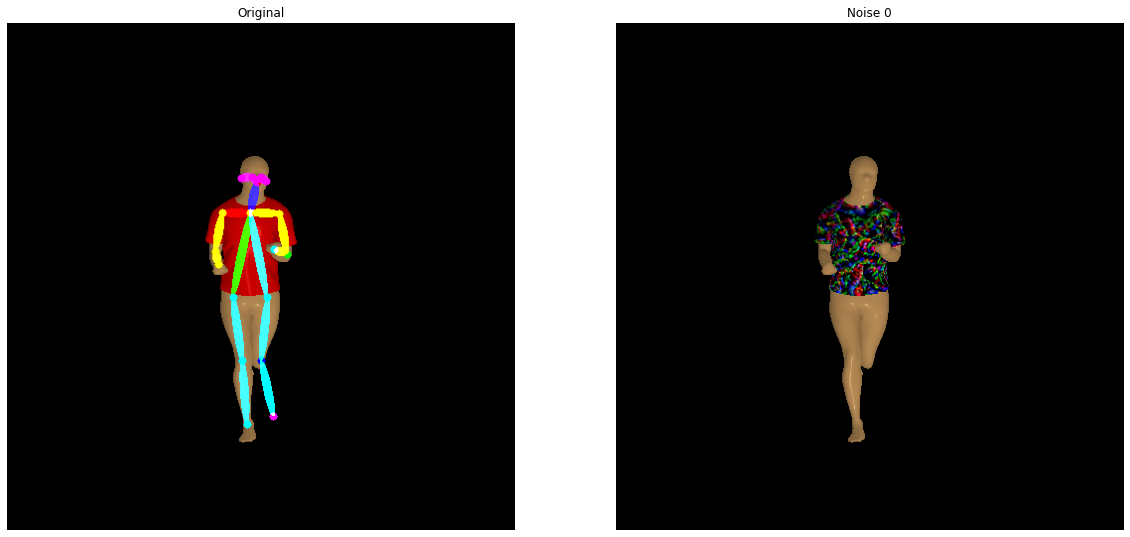

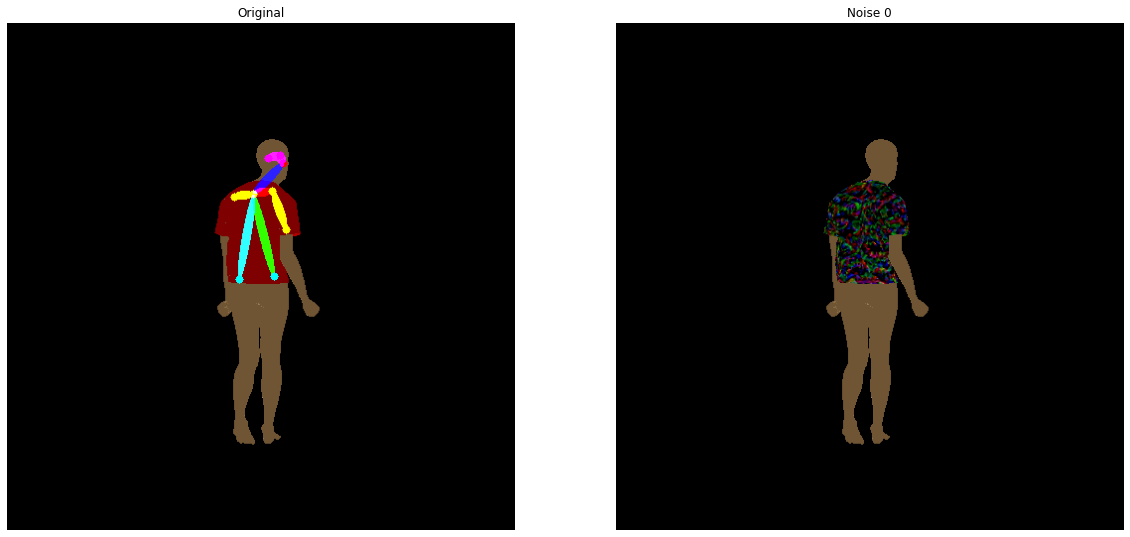

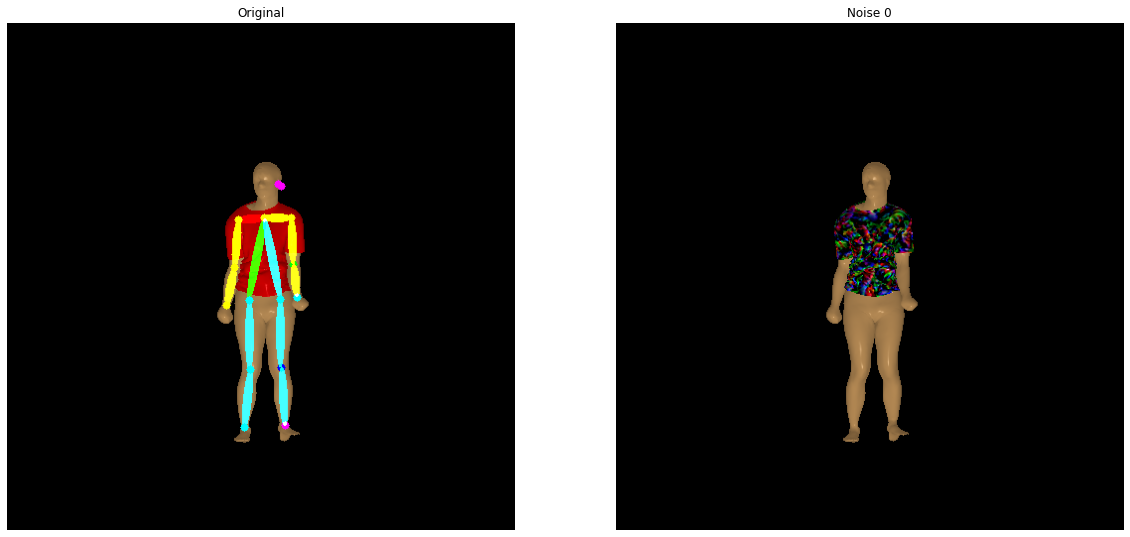

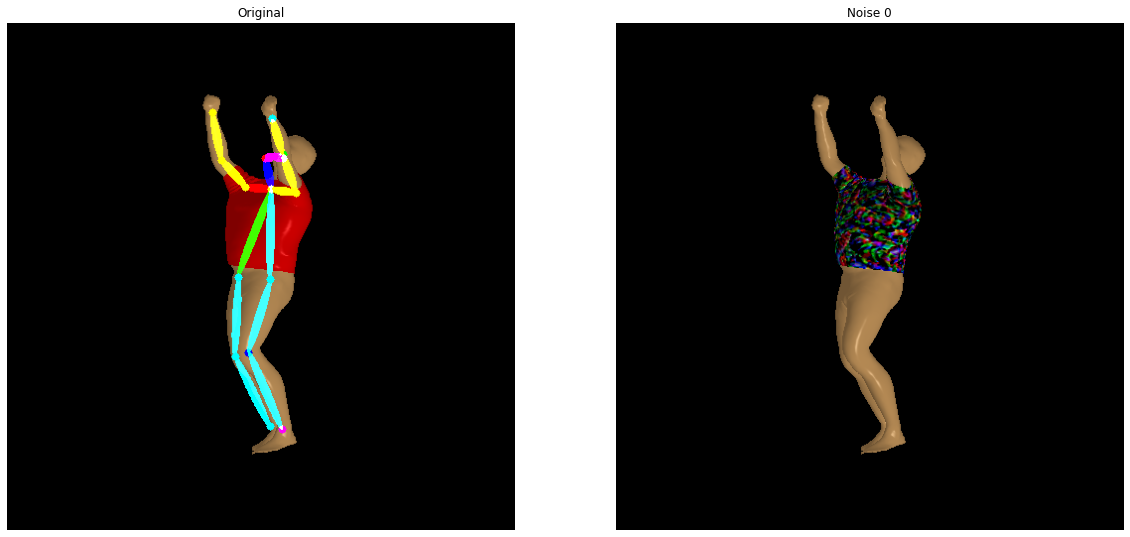

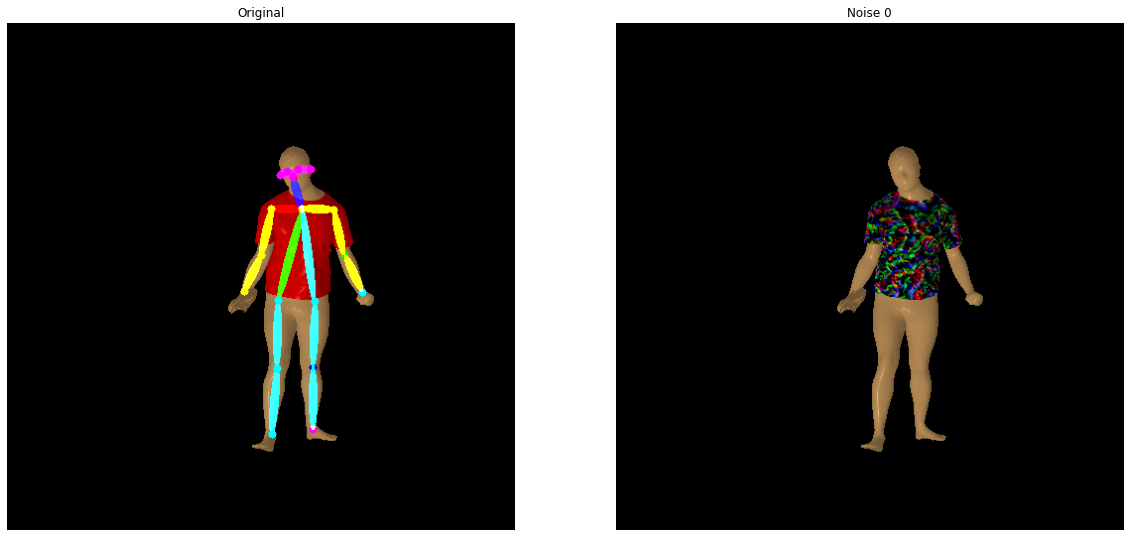

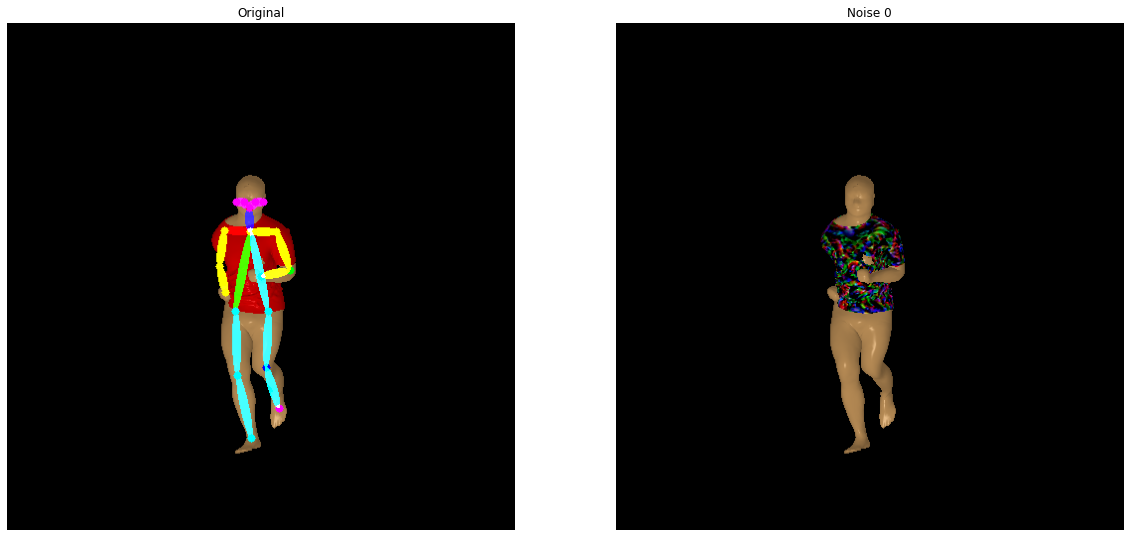

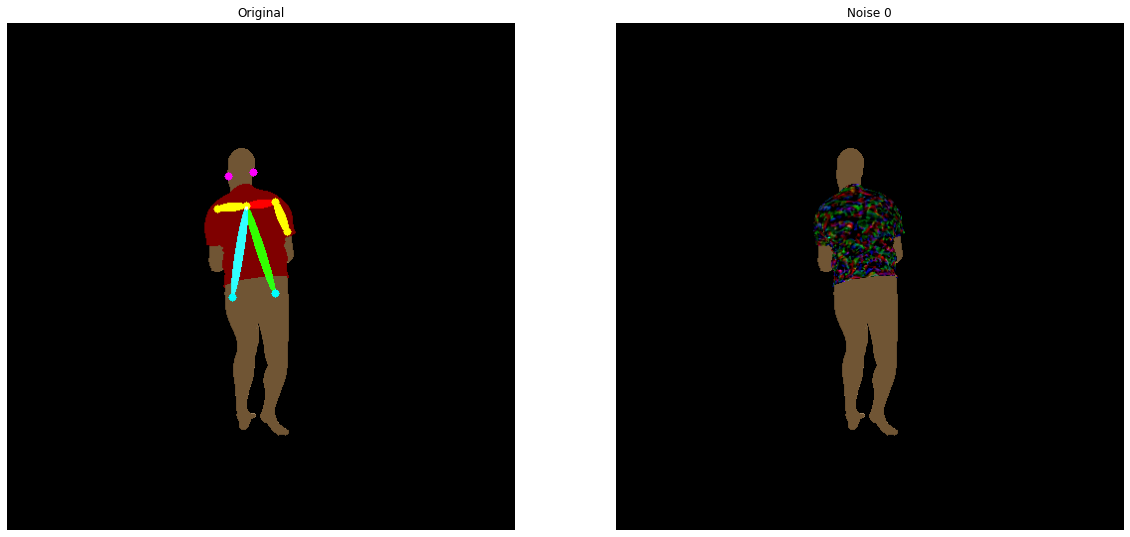

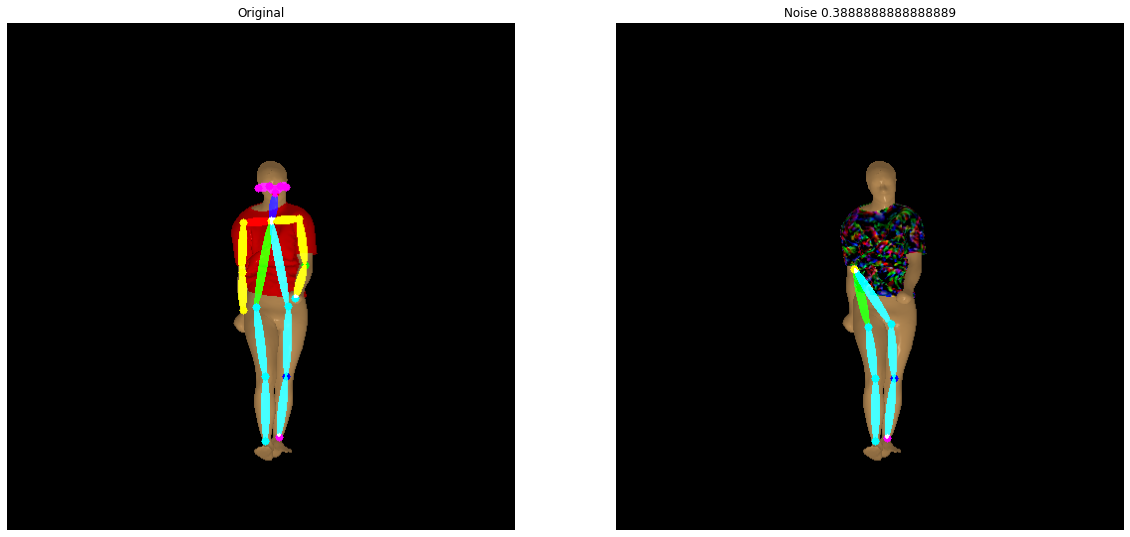

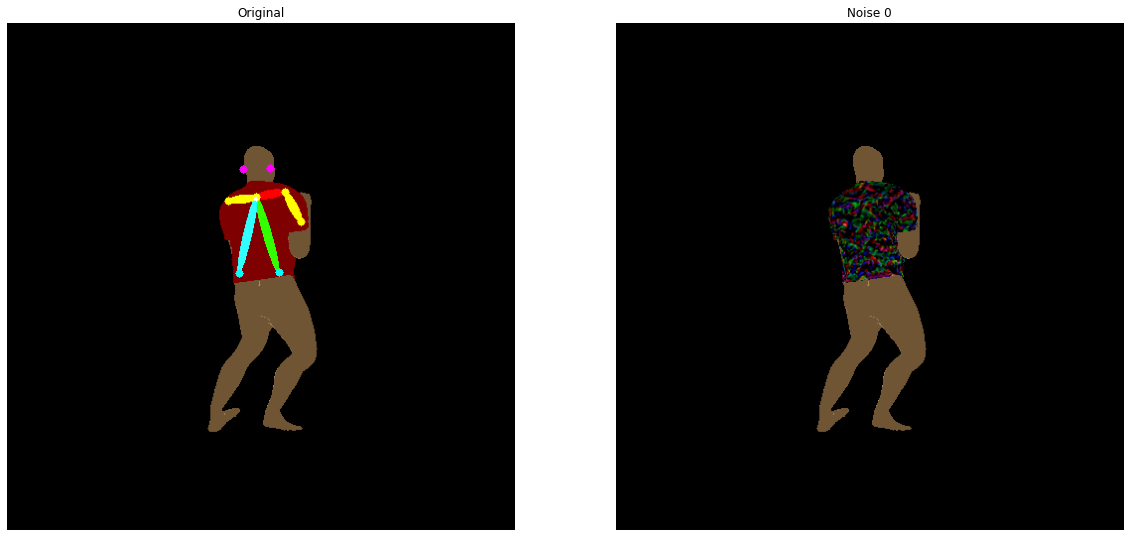

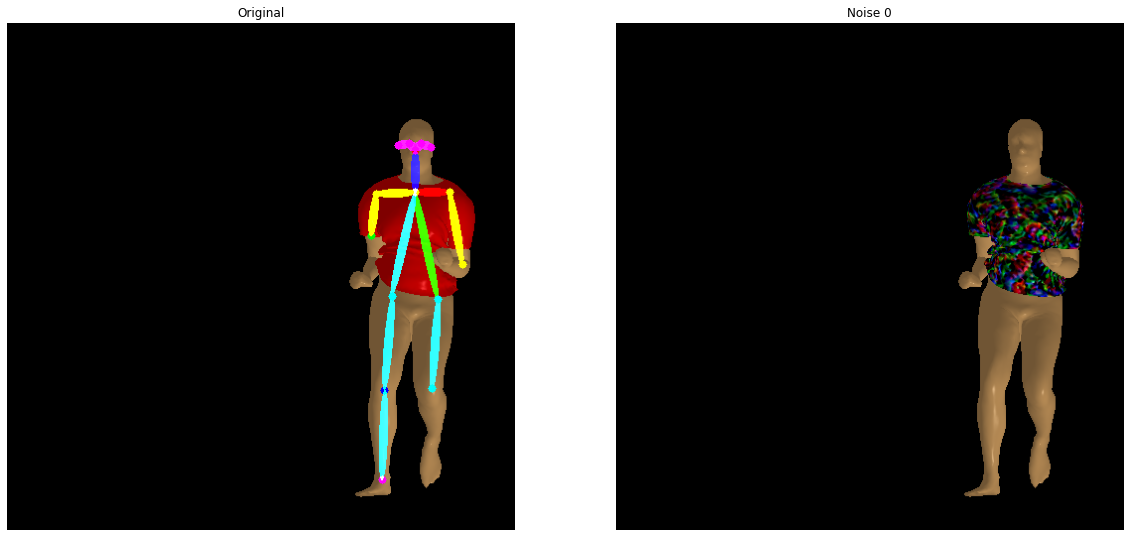

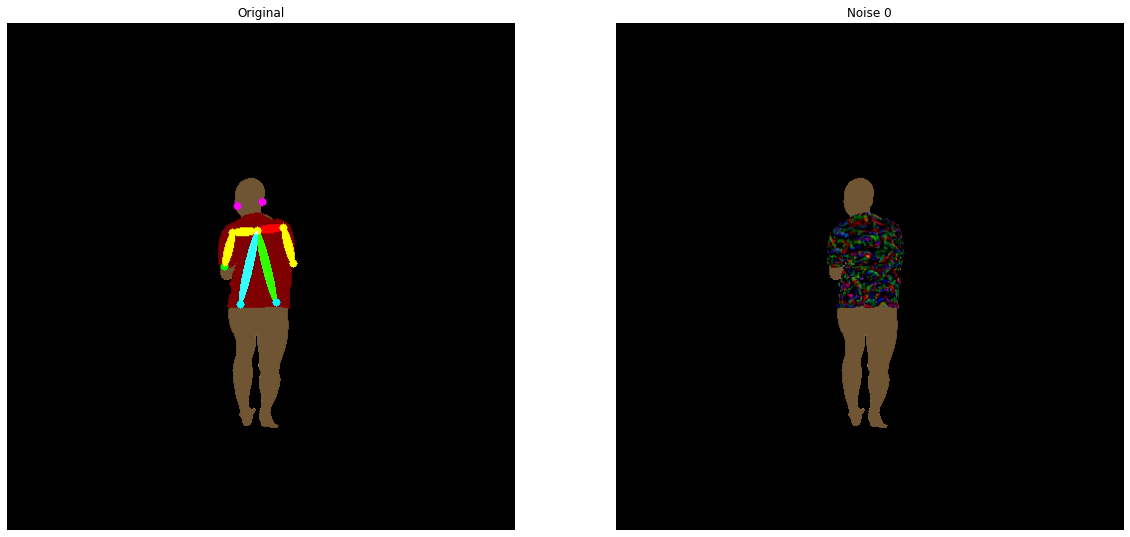

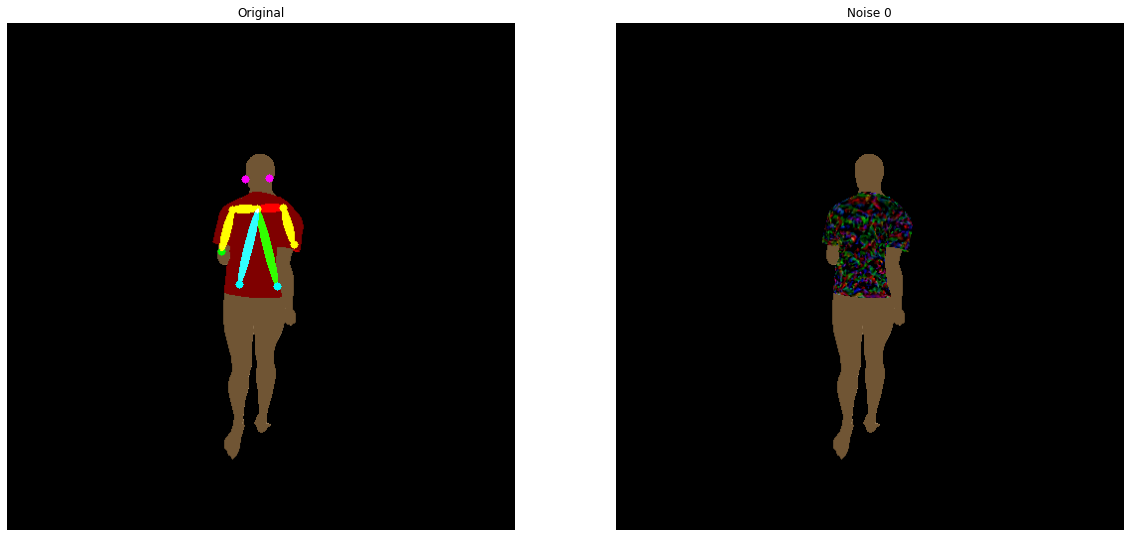

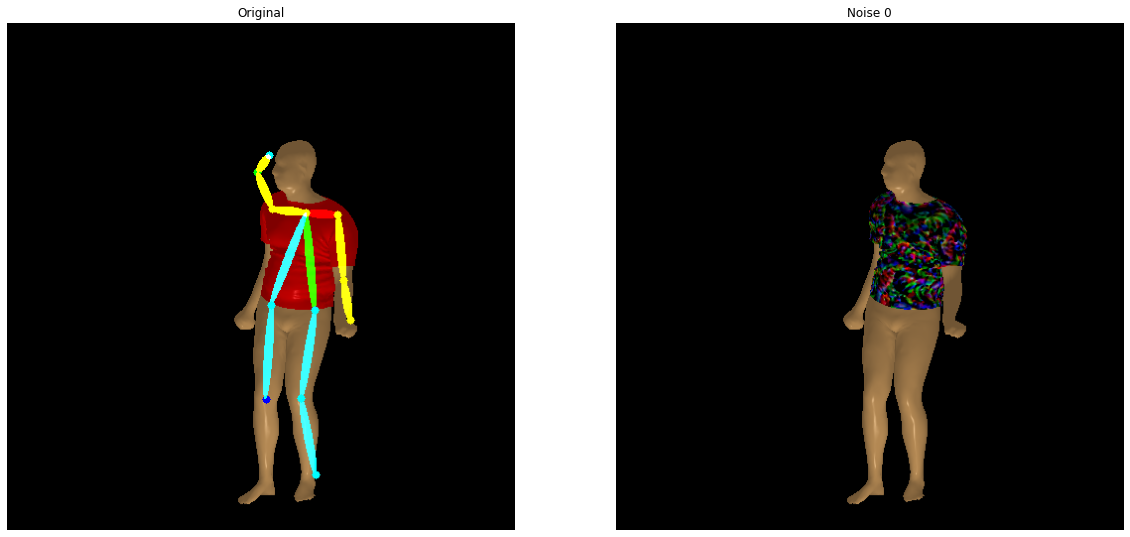

In [18]:
plot_cnt = 16
figures = []
for i in range(plot_cnt):
    fig = plt.figure(figsize=(20, 80))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(canvas_orig_list_filtered[i])
    ax.axis('off')
    ax.set_title('Original')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(canvas_noise_list_filtered[i])
    ax.axis('off')
    ax.set_title(f'Noise {metric_list_filtered[i]}')